In [ ]:
!apt-get install p7zip
!apt-get install p7zip-full 

# 1. Extract the data

In [ ]:
!7za e ../input/mercari-price-suggestion-challenge/train.tsv.7z
!7za e ../input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

In [ ]:
!7za e ../input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import scipy
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import shutil
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import math
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, hstack
from gensim.models import KeyedVectors
from prettytable import PrettyTable
import pickle
import zipfile
from tqdm import tqdm
import os
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from stop_words import get_stop_words
from collections import Counter
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, GRU, Dense,Flatten
from tensorflow.keras.models import Model,load_model
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from contextlib import contextmanager
tf.keras.backend.clear_session()

# 2. Load Data

In [ ]:
train_data = pd.read_csv('./train.tsv', sep='\t')
test_data = pd.read_csv('././test_stg2.tsv', sep='\t')

In [ ]:
print(train_data.shape)
print(test_data.shape)

# 3. Phân tích dữ liệu 

Trước tiên, chúng ta sẽ cùng xem trong tập dữ liệu train của chúng ta có những gì

In [ ]:
train_data.head()

Tập dữ liệu của chúng ta gồm các feature như sau:
* train_id: ID của sản phẩm
* name: tên của sản phẩm
* item_condition: điều kiện của sản phẩm, được cung cấp bới người bán, từ 1 đến 5 theo mức độ tốt giảm dân
* category_name: loại sản phẩm
* brand_name: thương hiệu của sản phẩm
* price: giá của sản phẩm
* shippng: bằng 0 nếu người mua tự trả phí ship, ngược lại thì bằng 1
* item_description: mô tả của sản phẩm
Trong phần tiếp theo, chúng ta cùng phân tích các feature nổi bật của dữ liệu từ đó sẽ có những hướng đi trong việc xử lý dữ liệu.
## Item_condition_id column


Như đã nói ở trên, giá trị của cột này phân bố từ 1 đến 5, chính vì vậy chúng ta có thể visualize dữ liệu để xem phân bố của cột này là như thế nào

In [ ]:
plt.title("Distribution of Item condition id")
plt.xlabel("Item condition id")
plt.ylabel("No. of item condition id")
plt.hist(train_data["item_condition_id"])

## Category_name column
Có thể thấy mỗi phần tử trong cột category_name được chia làm 3 phần, ngăn cách với nhau bởi dấu '/' và có thể thấy, theo thứ tự từ trái qua phải thì các giá trị sẽ có thể bao trùm nhau, nghĩa là có giá trị sẽ là con của 1 giá trị khác. Chẳng hạn, giá trị "Women/Jewelry/Necklaces" thì necklaces là con của Jewerly. Từ đó, chúng ta có 1 hướng để phân tích dữ liệu ở đây, đó là loại bỏ những dấu '/' và thêm 2 cột, mỗi cột là 1 giá trị sau dấu '/' của các sản phẩm. Bên cạnh đó, chúng ta cũng có thể nghĩ đến hướng sử dụng phương pháp Attention để đánh trọng số cho các giá trị quan trọng trong category_name. </br>
Tuy nhiên, đây sẽ là công việc ở phần sau. Trong phần này, chúng ta cùng xem, dữ liệu trong cột category_name gồm những gì! Hãy cùng xem phân bố của nó.

In [ ]:
category_count = train_data['category_name'].value_counts()
print(category_count)

Cùng xem, 15 giá trị có số lượng nhiều nhất trong cột category_name 

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
sns.barplot(x=category_count[:15].values, y=category_count[:15].index)
plt.title("Top 15 categories")
plt.xlabel('Counts', fontsize=13)
plt.show()

## Brand_name column
Tương tự với category_name column, chúng ta cùng xem 15 giá trị có số lượng nhiều nhất.
Tuy nhiên, có thể thấy, có một số giá trị trong cột mang giá trị NaN, chính vì vậy, chúng ta cần xử lý các giá trị này để việc train được hiệu quả. Công việc này, chúng ta sẽ thực hiện ở phần sau.

In [ ]:
brand_name_count = train_data['brand_name'].value_counts()
brand_name_count

In [ ]:
sns.set(style="whitegrid")
sns.barplot(x=brand_name_count[:15].values, y=brand_name_count[:15].index)
plt.title("Top 15 brand name")
plt.xlabel('Counts', fontsize=13)
plt.show()

## Price Column
Cùng xem phân bố của giá các sản phẩm

In [ ]:
train_data.price.describe()

Kết quả trên cho chúng ta thấy một số điều:
* Giá trung bình của các sản phẩm là ~26 USD
* Giá nhỏ nhất: 0 USD
* Giá lớn nhất 2009 USD
* 25% sản phẩm có giá dưới 10 USD, 50% sản phẩm có giá dưới 17% và 75% sản phẩm có giá dưới 29% </br>
Có thể thấy, vẫn tồn tại khá nhiều các sản phẩm có giá trị dưới 3 USD, nên một công việc cần làm ở phần sau đó là loại bỏ những sản phẩm này bởi Mercari chỉ chấp nhận những sản phẩm có giá trị không dưới 3 USD

In [ ]:
plt.title("Distribution of Price")
plt.xlabel("Price(USD)")
plt.ylabel("No. of products")
plt.hist(train_data['price'],bins=30)

Đồ thị đang bị lệch sang bên trái. Đây là điều chúng ta không hề mong muốn vì nó sẽ ảnh hưởng đến quá trình huấn luyện cũng như sẽ làm cho model không đạt được hiệu quả tốt nhất </br>
Đây cũng là công việc mà chúng ta cần làm trong phần xử lý dữ liệu 

## Item_description column

Cùng xem phân bố của từ thông qua Word Cloud. Nó sẽ giúp chúng ta xem từ nào xuất hiện nhiều nhất.

In [ ]:
import collections
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

word_counter = collections.Counter(train_data['item_description'])
most_common_words = word_counter.most_common(500)

stop_words = set(stopwords.words('english'))
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['rm'])
# stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(str(most_common_words))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word cloud generated from the item_descriptions\n")
plt.axis("off")
plt.show()

In [ ]:
train_data['description_wc'] = [len(str(i).split()) for i in train_data['item_description']]
plt.figure(figsize=(10,3))
sns.distplot(train_data.description_wc, hist=False)
plt.title('Plot of the word count for each item description')
plt.xlabel('Number of words in each description')
plt.show()

In [ ]:
train_data.description_wc.describe()

Như vậy, chúng ta đã có những cái nhìn tổng quát nhất về các cột dữ liệu của chúng ta. </br>
Trong phần tiếp theo, chúng ta sẽ xử lý dữ liệu để giải quyết các vấn đề mà đã nêu ở phần trên.

# 4. Xử lý dữ liệu
## Data clean

Mercari sẽ loại bỏ những sản phẩm dưới 3$ nên ta sẽ lại loại những sản phẩm đó ra khỏi tập train

In [ ]:
train_data = train_data.drop(train_data[(train_data.price < 3.0)].index)

In [ ]:
#số lượng phần tử đã giảm đi 
print(train_data.shape)

In [ ]:
train_data.head()

## Handing the null value

Trước tiên, ta kiểm tra xem có những cột nào sẽ có giá trị null

In [ ]:
print(train_data.isnull().sum())

In [ ]:
print(test_data.isnull().sum())

Như vậy, có tới 3 cột có null value, đó là category_name, brand_name, item_description.

In [ ]:
def fill_nan(data):
    data.item_description.fillna("No description yet",inplace=True)
    data.brand_name.fillna("missing",inplace=True)
    data.category_name.fillna("missing",inplace=True)

## Split the category_name

Như đã nói ở trên, chúng ta cần chia category_name thành 3 cột mới.

In [ ]:
def split_category(category):
    try:
        sub1, sub2, sub3 = category.split('/')
        return sub1, sub2, sub3
    except:
        return ("No Label", "No Label","No Label")
def create_split_categories(data):
    data['main_category'], data['sub_cat_1'], data['sub_cat_2'] = zip(*data.category_name.apply(lambda x: split_category(x)))

In [ ]:
def countwords(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0

In [ ]:
def log_price(price):
    return np.log1p(price)

## Scale the price
Như đã nói ở trên, việc phân bố của cột price bị lệch về phía trái sẽ làm cho hiệu quả model của chúng ta không được tốt. Một giải pháp được đưa ra là lấy log, chúng ta cùng xem hiệu quả của nó như nào.

In [ ]:
train_data['log_price'] = np.log1p(train_data.price)
plt.title("Distribution of log_price")
plt.xlabel("Log price")
plt.ylabel("No. of log price")
plt.hist(train_data.log_price)

Tuy nhiên, khi so sánh, chúng ta cần sử dụng kết quả ban đầu, chính vì vậy, ta cần scale lại giá trị dự đoán để phục vụ cho việc tính hàm lỗi

In [ ]:
def scale_back(x):
    '''
    Function to inverse transform the scaled values
    '''
    x= np.expm1(y_scalar.inverse_transform(x.reshape(-1,1))[:,0])#changes
    return x

## Split Train-Test
Đây là bước chúng ta sẽ tạo tập test từ tập train. Mục đích là để chúng ta có đánh giá tốt nhất về phương pháp cũng như mô hình của chúng ta trước khi submiss. </br>
Thông thường, chúng ta sẽ lấy dữ liệu tập test bằng 20% dữ liệu của tập train 


In [ ]:
from sklearn.model_selection import train_test_split
def split(data):
    X_train, X_test= train_test_split(data, test_size=0.20, random_state=123)
    return X_train, X_test

## Embedding
Dữ liệu chúng ta gồm 2 loại chính: categorical feature và text feature
### Category feature embedding

In [ ]:
def rank_category(dataset,column_name):
    '''This function takes a column name which is categorical and returns the categories with rank'''
    counter = dataset[column_name].value_counts().index.values
    total = list(dataset[column_name])
    ranked_cat = {}
    for i in range(1,len(counter)+1):
        ranked_cat.update({counter[i-1] : i})
    return ranked_cat,len(counter)

def encode_ranked_category(train,test,column):
    '''
    This function calls the rank_category function and returns the encoded category column    '''
    train[column] = train[column].astype('category')
    test[column] = test[column].astype('category')
    
    cat_list = list(train[column].unique())
    ranked_cat_tr,count = rank_category(train,column)

    encoded_col_tr = []
    encoded_col_te = []

    for category in train[column]:
        encoded_col_tr.append(ranked_cat_tr[category])

    for category in test[column]:
        if category in cat_list:
            encoded_col_te.append(ranked_cat_tr[category])
        else:
            encoded_col_te.append(0)
    
    encoded_col_tr = np.asarray(encoded_col_tr)
    encoded_col_te = np.asarray(encoded_col_te)
    return encoded_col_tr,encoded_col_te,count

### Text Embedding

In [ ]:
def tokenize_text(train,test,column):
    global t
    t = Tokenizer()
    t.fit_on_texts(train[column].str.lower())
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_text_tr = t.texts_to_sequences(train[column].str.lower())
    encoded_text_te = t.texts_to_sequences(test[column].str.lower())
    return encoded_text_tr,encoded_text_te,vocab_size

# 5. Model 
Trong bài này, em sử dụng GRU để giải quyết để trích xuất những đặc trưng và concentrate thành một feature vector, sau đó đưa qua mạng MLP để dự đoán kết quả. chúng ta cùng tìm hiểu về GRU và đầu tiên là một khái niệm liên quan đến GRU, đó là RNN.
RNN (Recurrent Neutral Network) là sử dụng chuỗi thông tin. Các mạng nơ-ron truyền thống thường xử lý các input và output một cách độc lập. Tuy nhiên, có thể thấy, nó sẽ không phù hợp trong nhiều trường hợp, chẳng hạn như trong các bài toán dự đoán từ ngữ, chúng ta cũng cần dựa vào các input trc đó để dự đoán. RNN sinh ra để giải quyết vấn đề này. Nói cách khác, RNN có thể nhớ được các thông tin đã được tính toán trước đó. Cụ thể về cấu trúc chúng ta có thể được nhìn thấy như hình dưới. Điểm khác biệt của RNN với các mô hình truyền thống, đó là, ở hidden state, ngoài embedding vector của đầu vào thứ i, thì input ở hidden state này còn có thêm h(i-1), hidden state của lớp trước đó. Đó là lí do vì sao chúng ta lại nói RNN có thể nhớ được các thông tin của các dữ liệu đã được xử lý trước đó 

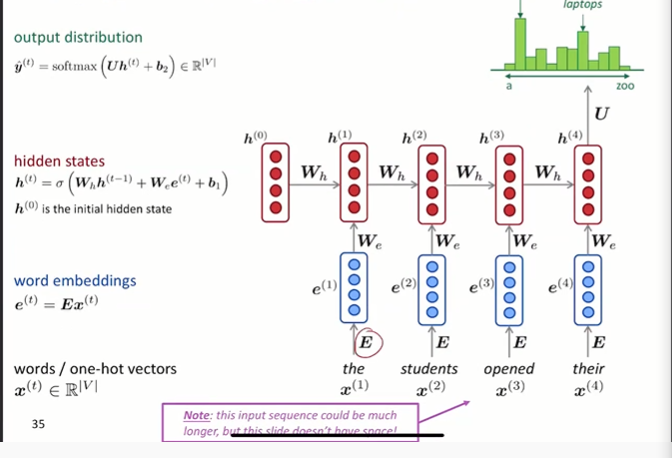 

Tuy nhiên, độ lưu trữ thông tin của RNN là không cao và xảy ra 1 hiện tượng rất phổ biến, đó là vanishing gradient. Nghĩa là đối với các từ ở xa nhau, khi backdrop, đạo hàm tại các vị trí xa gần như bằng 0, chính vì vậy, lượng thông tin mang đến là không trọn vẹn. GRU là một bản nâng cấp của RNN để xử lý vấn đề đó. Cấu trúc của GRU được thể hiện như hình dưới đây <br>
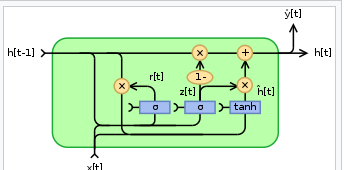
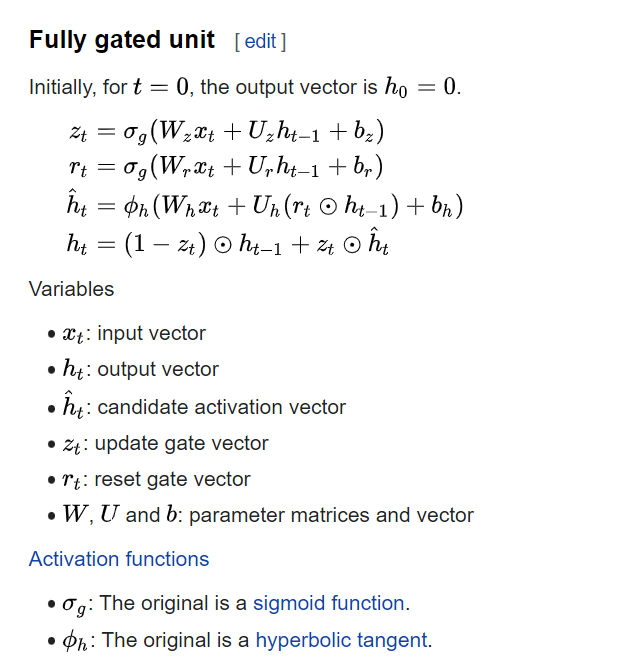
<br>Để giải quyết vấn đề vanishing gradient, GRU sử dụng cổng cập nhật và cổng cài đặt lại (update gate và reset gate). Về cơ bản, đó chính là hai vector quyết định thông tin nào sẽ được truyền cho đầu ra. Điều đặc biệt là nó có thể được đào tạo để giữ thông tin từ lâu trước đó, không hề xóa thông tin không liên quan đến dự đoán đầu ra. 
* Cổng cập nhật(update gate) giúp mô hình xác định được lượng thông tin trong quá khứ (thông tin ở bước t-1) cần chuyển đến tương lai (bước t)
* Cổng cài đặt lại (reset gate) được sử dụng để quyết đinh lượng thông tin trong quá khứ bị quên đi.

In [ ]:
# Set the parameters for model
def data_gru(train,test):
    
    global max_length,desc_size,name_size
    encoded_brand_tr,encoded_brand_te,brand_len = encode_ranked_category(train,test,'brand_name')
    encoded_main_cat_tr,encoded_main_cat_te,main_cat_len = encode_ranked_category(train,test,'main_category')
    encoded_sub_cat_1_tr,encoded_sub_cat_1_te,sub_cat1_len = encode_ranked_category(train,test,'sub_cat_1')
    encoded_sub_cat_2_tr,encoded_sub_cat_2_te,sub_cat2_len = encode_ranked_category(train,test,'sub_cat_2')
    
    tokenized_desc_tr,tokenized_desc_te,desc_size = tokenize_text(train,test,'item_description')
     
    tokenized_name_tr,tokenized_name_te,name_size = tokenize_text(train,test,'name')
      
    max_length = 160
    desc_tr_padded = pad_sequences(tokenized_desc_tr, maxlen=max_length, padding='post')
    desc_te_padded = pad_sequences(tokenized_desc_te, maxlen=max_length, padding='post')
    del tokenized_desc_tr,tokenized_desc_te

    name_tr_padded = pad_sequences(tokenized_name_tr, maxlen=10, padding='post')
    name_te_padded = pad_sequences(tokenized_name_te, maxlen=10, padding='post')
    del tokenized_name_tr,tokenized_name_te

    gc.collect()

    train_inputs = [name_tr_padded,desc_tr_padded,encoded_brand_tr.reshape(-1,1),\
                    encoded_main_cat_tr.reshape(-1,1),encoded_sub_cat_1_tr.reshape(-1,1),\
                    encoded_sub_cat_2_tr.reshape(-1,1),train['shipping'],\
                    train['item_condition_id'],train['wc_desc'],\
                    train['wc_name']]
    test_inputs = [name_te_padded,desc_te_padded,encoded_brand_te.reshape(-1,1),\
                    encoded_main_cat_te.reshape(-1,1),encoded_sub_cat_1_te.reshape(-1,1),\
                    encoded_sub_cat_2_te.reshape(-1,1),test['shipping'],\
                    test['item_condition_id'],test['wc_desc'],\
                    test['wc_name']]
    
    item_condition_counter = train['item_condition_id'].value_counts().index.values

    list_var = [brand_len,main_cat_len,sub_cat1_len,sub_cat2_len,len(item_condition_counter)]
    
    return train_inputs,test_inputs,list_var

Như đã nói ở trên, chúng ta sử dụng GRU để tính toán, trích chọn đặc trưng cho các feature, sau đó kết hợp tất cả các vector lại, thu được một feature vector là đầu vào của 1 mạng nơ-ron. Bên cạnh đó, chúng ta cũng sử dụng thêm các lớp drop-out và batch-normalization:
* Drop-out: là quá trình chúng ta giả định một số unit sẽ ẩn đi trong quá trình training, qua đó có thể giảm hiện tượng overfitting khi training <br>
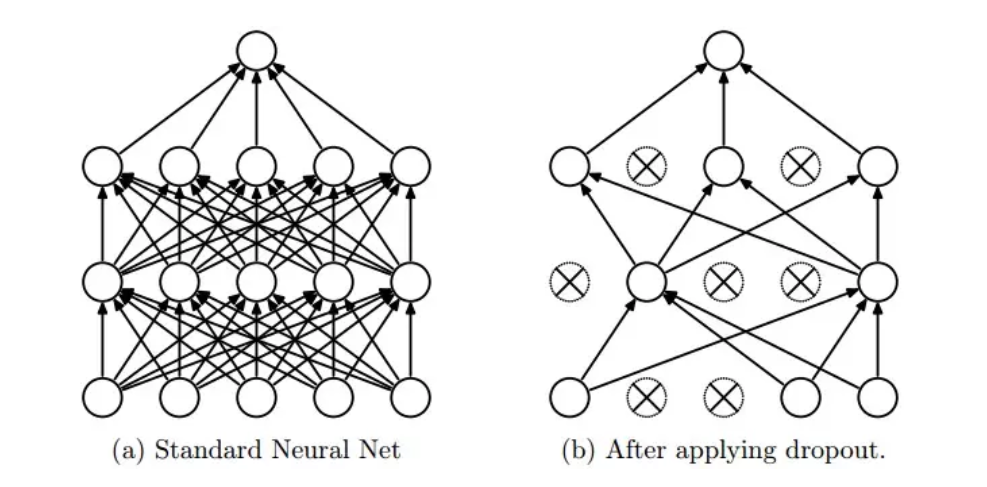
<br>
* Batch_Normalization: là một kỹ thuật để đào tạo mạng nơ ron sâu, chuẩn hóa các đầu vào thành một layer cho mỗi mini-batch. Điều này có tác dụng ổn định quá trình học tập và giảm đáng kể số lượng epoch đào tạo cần thiết để đào tạo mạng sâu. Bên cạnh đó bath_norm cũng sẽ chuẩn hóa các feature về trạng thái non-zero (dữ liệu phân bố quanh 0) với độ lệch chuẩn là 1  <br>
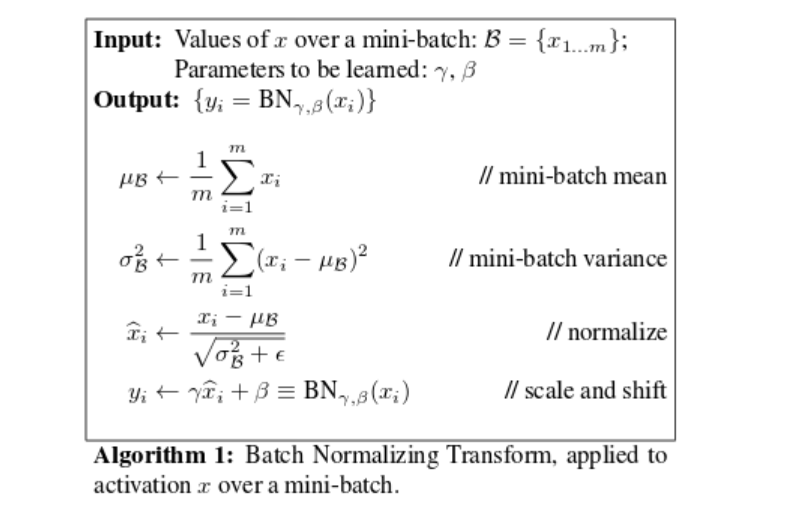
<br>
* Để hiểu thêm về MLP, chúng ta có thể tham khải bài giảng trong khóa học Học máy: https://tricky-tax-444.notion.site/04-M-ng-n-ron-nhi-u-l-p-e6b853c5903e467f9d74a8bd8b357ef2#749c48471ea146d1be99117b91cb4840 
<br>
* Còn về cấu trúc mang MLP của bài toán sẽ được mô tả qua hình dưới đây: <br>



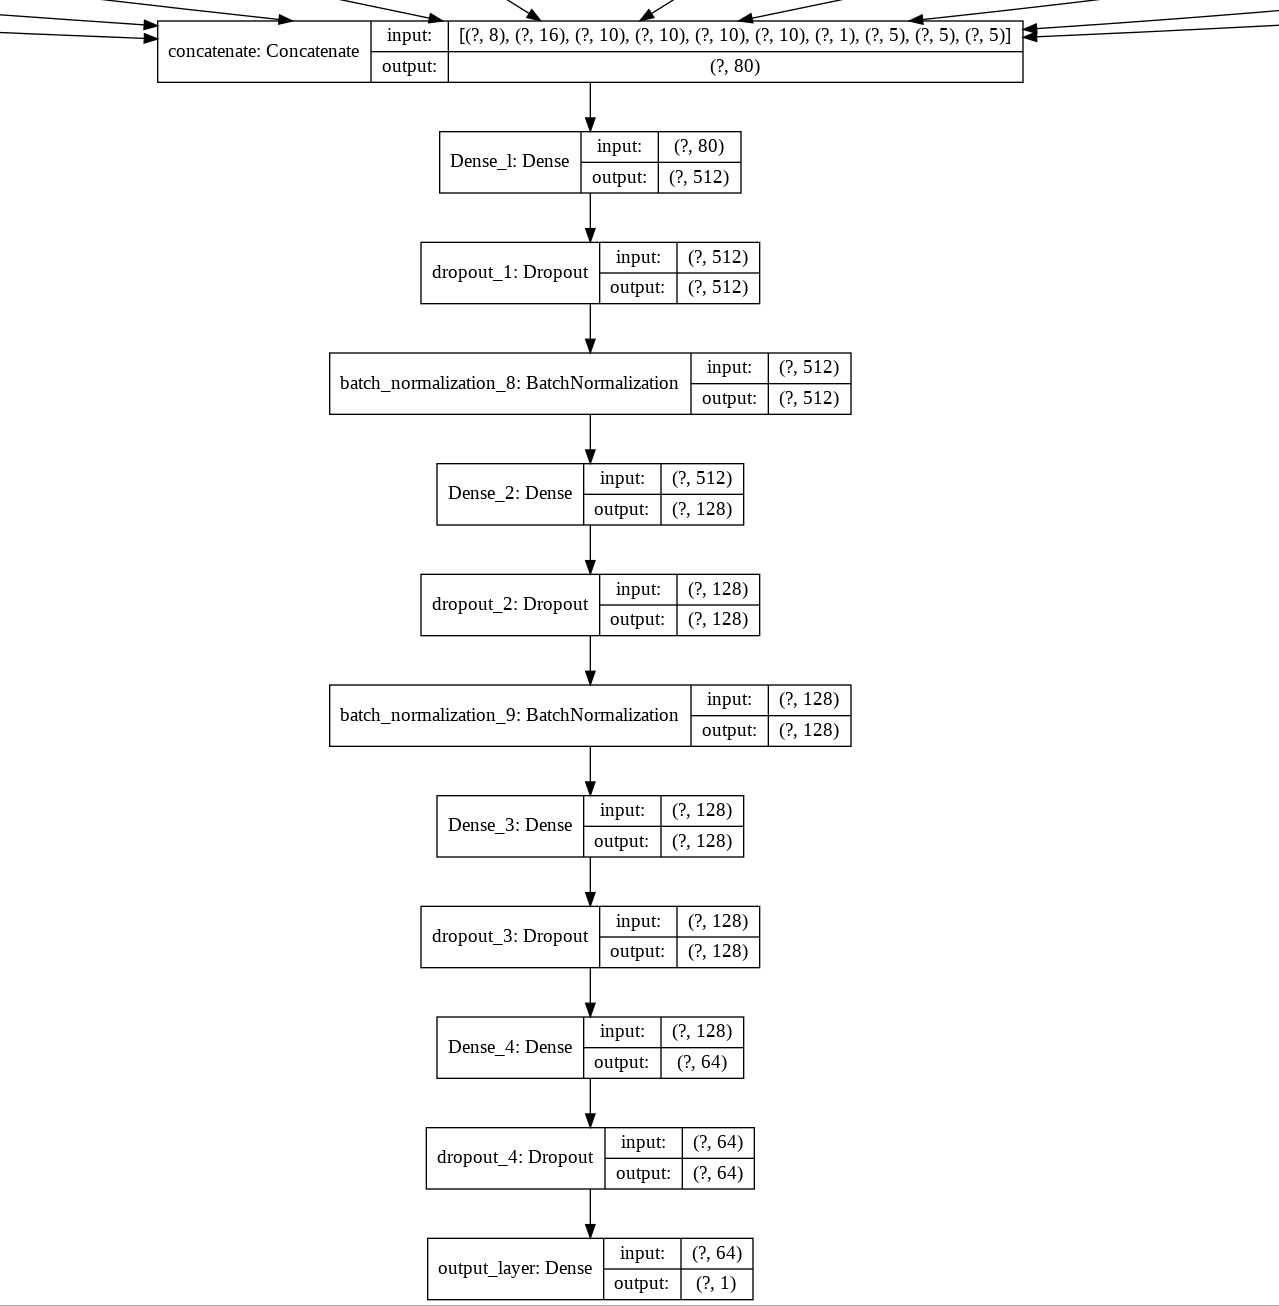

In [ ]:
def construct_GRU(train,var_list,drop_out_list):
    #GRU input layer for name
    input_name =  tf.keras.layers.Input(shape=(10,), name='name')
    embedding_name = tf.keras.layers.Embedding(name_size, 20)(input_name)
    gru_name = tf.keras.layers.GRU(8)(embedding_name)
    #GRU input layer for description
    input_desc =  tf.keras.layers.Input(shape=(max_length,), name='desc')
    embedding_desc = tf.keras.layers.Embedding(desc_size, 60)(input_desc)
    gru_desc = tf.keras.layers.GRU(16)(embedding_desc)

    #input layer for brand_name
    input_brand =  tf.keras.layers.Input(shape=(1,), name='brand')
    embedding_brand = tf.keras.layers.Embedding(var_list[0] + 1, 10)(input_brand)
    flatten1 = tf.keras.layers.Flatten()(embedding_brand)

    #categorical input layer main_category
    input_cat = tf.keras.layers.Input(shape=(1,), name='main_cat')
    Embed_cat = tf.keras.layers.Embedding(var_list[1] + 1, \
                                          10,input_length=1)(input_cat)
    flatten2 = tf.keras.layers.Flatten()(Embed_cat)

    #categorical input layer sub_cat_1
    input_subcat1 = tf.keras.layers.Input(shape=(1,), name='subcat1')
    Embed_subcat1 = tf.keras.layers.Embedding(var_list[2] + 1, \
                                              10,input_length=1)(input_subcat1)
    flatten3 = tf.keras.layers.Flatten()(Embed_subcat1)

    #categorical input layer sub_cat_2
    input_subcat2 = tf.keras.layers.Input(shape=(1,), name='subcat2')
    Embed_subcat2 = tf.keras.layers.Embedding(var_list[3] + 1, \
                                              10,input_length=1)(input_subcat2)
    flatten4 = tf.keras.layers.Flatten()(Embed_subcat2)
    #categorical input layer shipping
    input_shipping = tf.keras.layers.Input(shape=(1,), name='shipping')

    #categorical input layer item_condition_id
    input_item = tf.keras.layers.Input(shape=(1,), name='item_condition_id')
    Embed_item = tf.keras.layers.Embedding(var_list[4] + 1, \
                                           5,input_length=1)(input_item)
    flatten5 = tf.keras.layers.Flatten()(Embed_item)

    #numerical input layer
    desc_len_input = tf.keras.layers.Input(shape=(1,), name='description_length')
    desc_len_embd = tf.keras.layers.Embedding(DESC_LEN,5)(desc_len_input)
    flatten6 = tf.keras.layers.Flatten()(desc_len_embd)

    #name_len input layer
    name_len_input = tf.keras.layers.Input(shape=(1,), name='name_length')
    name_len_embd = tf.keras.layers.Embedding(NAME_LEN,5)(name_len_input)
    flatten7 = tf.keras.layers.Flatten()(name_len_embd)

    # concatenating the outputs
    concat_layer = tf.keras.layers.concatenate(inputs=[gru_name,gru_desc,flatten1,flatten2,flatten3,flatten4,input_shipping,flatten5,\
                                                       flatten6,flatten7],name="concatenate")
    #dense layers use drop-out and batch-normalization
    Dense_layer1 = tf.keras.layers.Dense(units=512,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_l")(concat_layer)
    dropout_1 = tf.keras.layers.Dropout(drop_out_list[0],name='dropout_1')(Dense_layer1)
    batch_n1 = tf.keras.layers.BatchNormalization()(dropout_1)
    
    Dense_layer2 = tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_2")(batch_n1)
    dropout_2 = tf.keras.layers.Dropout(drop_out_list[1],name='dropout_2')(Dense_layer2)
    batch_n2 = tf.keras.layers.BatchNormalization()(dropout_2)

    Dense_layer3 = tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_3")(batch_n2)
    dropout_3 = tf.keras.layers.Dropout(drop_out_list[2],name='dropout_3')(Dense_layer3)

    Dense_layer4 = tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_4")(dropout_3)
    dropout_4 = tf.keras.layers.Dropout(drop_out_list[3],name='dropout_4')(Dense_layer4)
    
    #output_layer
    final_output = tf.keras.layers.Dense(units=1,activation='linear',name='output_layer')(dropout_4)

    model = tf.keras.Model(inputs=[input_name,input_desc,input_brand,input_cat,input_subcat1,input_subcat2,\
                                   input_shipping,input_item,desc_len_input,name_len_input],
                           outputs=[final_output])
    # visualize the model
    print(model.summary())

    return model

## Error Metric
Metric chúng ta sử dụng để đánh giá mô hình chính là RMSLE (The Root Mean Squared Log Error), được tính bởi công thức: <br>
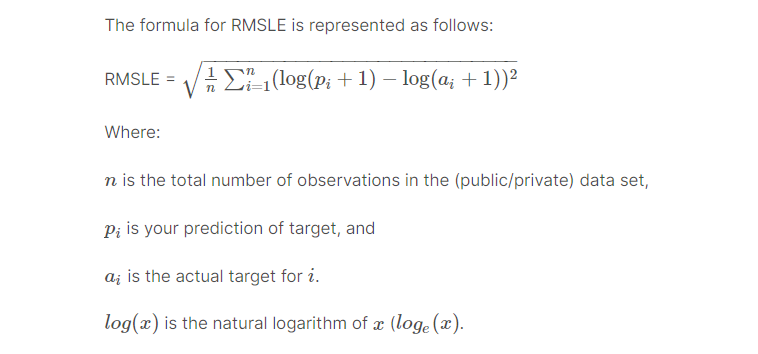
<br>

    

In [ ]:
def rmsle_compute(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    score = np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
    return score

def scale_back(x):
    '''
    Function to inverse transform the scaled values
    '''
    x= np.expm1(y_scalar.inverse_transform(x.reshape(-1,1))[:,0])#changes
    return x

# 6. Chạy thực nghiệm

## Training

In [ ]:
#Fill the null
fill_nan(train_data)
fill_nan(test_data)
print("filled nan\n")

#Data cleaning and preprocessing
train_data['wc_desc'] = train_data['item_description'].apply(lambda x: countwords(x))
test_data['wc_desc'] = test_data['item_description'].apply(lambda x: countwords(x))
train_data['wc_name'] = train_data['name'].apply(lambda x: countwords(x))
test_data['wc_name'] = test_data['name'].apply(lambda x: countwords(x))
create_split_categories(train_data)
create_split_categories(test_data)
print("Completed data cleaning and preprocessing\n")

#Split the data, create test data
X_train, X_test= train_test_split(train_data, test_size=0.20, random_state=123)
print("shape of X_train: {}".format(X_train.shape))
print("shape of X_test: {}".format(X_test.shape))

#Create target values
global y_scalar,DESC_LEN,NAME_LEN
y_scalar = StandardScaler()#changes
y_train = y_scalar.fit_transform(log_price(X_train['price']).values.reshape(-1, 1))#changes
y_test = y_scalar.transform(log_price(X_test['price']).values.reshape(-1, 1))#


In [ ]:
DESC_LEN = train_data.wc_desc.max() + 1
NAME_LEN = train_data.wc_name.max() + 1

In [ ]:
train_inputs,test_inputs,list_var = data_gru(X_test,test_data)

In [ ]:
filepath="GRU_lr-{epoch:03d}-{val_loss:.3f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
def scheduler(epoch):
    if epoch < 2:
        return 0.005
    else:
        return 0.001

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
call_backs = [model_checkpoint,lr_schedule]

In [ ]:
#learning_rate = default
#drop_outs = 0.10,0.10,0.20,0.20

# dropout_list1 = [0.10,0.10,0.20,0.20]
# model1 = construct_GRU(train_inputs, list_var, dropout_list1)
# model1.compile(optimizer='adam', loss='mean_squared_error')
# model1.fit(train_inputs, y_test, epochs=3,batch_size=2**10, callbacks=call_backs,validation_split=0.1)

In [ ]:
# predict_train1 = model1.predict(train_inputs)

In [ ]:
# print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(predict_train1))))

In [ ]:
# learning_rate = default
# drop_outs = 0.10,0.20,0.20,0.40
dropout_list2 = [0.10,0.20,0.20,0.40]
model2 = construct_GRU(train_inputs, list_var, dropout_list2)
model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(train_inputs, y_test, epochs=3,batch_size=2**10, callbacks=call_backs,validation_split=0.1)

In [ ]:
# predict_train2 = model2.predict(train_inputs)

In [ ]:
# print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(predict_train2))))

## Submission

In [ ]:
# prediction_1 = model1.predict(test_inputs)
prediction_2= model2.predict(test_inputs)

In [ ]:
# y_hats = np.array([prediction_1,prediction_2])
# mean_preds = np.mean(y_hats, axis=0)

In [ ]:
true_prediction = scale_back(prediction_2)

In [ ]:
true_prediction.shape

In [ ]:
true_prediction

In [ ]:
submission = pd.read_csv('sample_submission_stg2.csv')
submission

In [ ]:
submission.loc[:, 'price'] = true_prediction
submission

In [ ]:
submission.to_csv('submission.csv', index=False)

# 7. Rank 
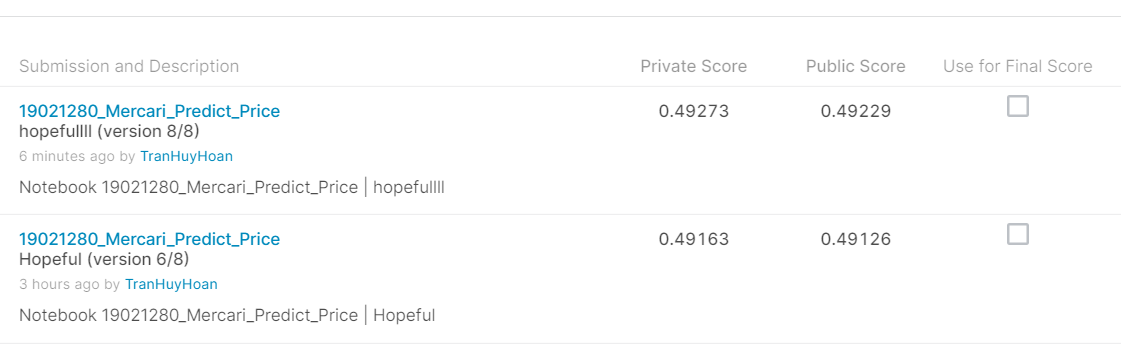